Simulate data based on the MPro data from moonshot to compare data for uni- and multivariant fitting

Simulation is done using pysb (BioNetGen)

For the analysis use enzyme and substrate conc and Km from Wal Ward "Methods to analyse Mpro time-course data for irreversible inhibitors" 
Enzyme = 5 nM, but assume Kd for dimer of 2.5 uM, only dimer is active, concentraiton of active enzyme = 0.039 nM
Substrate = 375 nM
Km = 50 uM
Assume kcat/Km = 28.500 (10.1038/s41586-020-2223-y), thus kcat= 1.425

In [3]:
#Imports
from pysb import *
from pysb import pathfinder
from pysb.integrate import Solver
from pysb.integrate import odesolve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import exp, sin
import random
from lmfit import minimize, Parameters
from tqdm import tqdm
from scipy.integrate import odeint, solve_ivp
import time, csv, os, xlrd, glob
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, GridspecLayout, Output, VBox
import ipywidgets as widgets
from IPython import display
import plotly as py
pathfinder.set_path("bng", "/Users/nope/Downloads/RuleBender-2.1.0.8-osx64/BioNetGen-2.2.6")

First all functions used for simluation and fitting are importet

In [4]:
def simulate_kinact(time = np.linspace(0, 60*60, 30), ki1_rate = 1e+7, kim1_rate = 1e-0, 
                    kinact_rate = 1e-3, sub_rates = (2e+4, 1e-0), kcat_rate = 1.425,
                    inhib_concs = [float(20000.)/np.power(2,x) for x in range(18)] ):
    """Simulate activity data for a covalent inhibitor"""
    ars = {}
    avo = 6.02e23
    nm = 1e-9
    for rate in ["1"]: #This is an artifact from older versions
        ar = []
        print(rate)
        for inhib_conc in inhib_concs:

            Model()
            # Declare the monomers
            Monomer('E', ['s', 'i', 'c'], {'c' : ["encounter", "covalent"]})
            Monomer('P', ['s', 'pro'], {'pro' : ["sub", "pro"]})
            Monomer('I', ['i'])

            # Declare the parameters
            Parameter('E_0', 0.039)
            Parameter('P_0', 375.)
            Parameter('I_0', inhib_conc)
            Parameter('kp1', sub_rates[0]*nm) 
            Parameter('kpm1', sub_rates[1])
            Parameter('ki1', ki1_rate*nm)
            Parameter('kim1', kim1_rate)
            Parameter('kinact', kinact_rate)
            Parameter('kcat', kcat_rate)

            # Declare the initial conditions
            Initial(E(s=None, i = None, c = "encounter"), E_0)
            Initial(I(i=None), I_0)
            Initial(P(s=None, pro = "sub"), P_0)
  
            # Declare the binding rule
            Rule('E_binds_P', E(s=None, i=None, c = "encounter") + P(s=None, pro = "sub") <> E(s=1, i=None, c = "encounter") % P(s=1, pro = "sub"), kp1, kpm1)
            Rule('EP_cat_and_diss', E(s=1, i=None, c = "encounter") % P(s=1, pro = "sub") >> E(s=None, i=None, c = "encounter") + P(s=None, pro="pro"), kcat)
            Rule('E_binds_I', E(s=None, i=None, c = "encounter") + I(i=None) <> E(s=None, i=1, c = "encounter") % I(i=1), ki1, kim1)
            Rule('EI_to_EIcov', E(s=None, i=1, c = "encounter") % I(i=1) >> E(s=None, i=1, c = "covalent") % I(i=1), kinact)

            # Observe the complex
            Observable('EP_Complex', E(s=1, i=None, c = None) % P(s=1, pro = "sub"))
            Observable('Product', P(s=None, pro = "pro"))
            #if n not in results.keys():
            #    results[n] = {}
            #results[n][inhib_conc] = (odesolve(model, time, compiler = "python"))['EP_Complex'] 
            ar.append((odesolve(model, time, compiler = "python")))
        ars["_".join([str(x) for x in rate])] = ar
        ar = []
    return ars

def save_rda_figs(ars, inhib_concs, time):
    """Save figure of product formation over time"""
    for key in ars.keys():
        plt.clf()
        for i in range(len(inhib_concs)):
            plt.plot(time, ars[key][i]['Product'], label = str(inhib_concs[i]) + " nM")
        plt.xlabel('Time (seconds)')
        plt.ylabel('Product')
        plt.title(key)
        plt.savefig(key + ".png", dpi = 300)
    plt.clf()

def steady_state_out(ars, inhib_concs, scale = 6000):
    """Save endpoint values for IC50 fit"""
    for x,key in enumerate(sorted(ars.keys())):
        temp = []
        for i in range(len(inhib_concs)):
            temp.append((inhib_concs[i],ars[key][i]['Product'][-1]*1e9*scale))
        if x == 0:
            eq = pd.DataFrame(temp, columns = ["Conc", key])
        else:
            eq = pd.merge(eq, pd.DataFrame(temp, columns = ["Conc", key]), on = "Conc")
    eq.to_excel("steady state.xlsx")  
    return eq

def make_dfs(ars, time, inhib_concs, scale):
    """Make a dataframe from product produced over time in the simulated data"""
    dfs = {}
    for x,key in enumerate(sorted(ars.keys())):
        for i in range(len(inhib_concs)):
            if i == 0:
                dft = pd.DataFrame([time, ars[key][i]["Product"]*1e9*scale]).T.rename(columns = {0 : "time", 1: inhib_concs[i]})
            else:
                dft = pd.merge(dft, pd.DataFrame([time, ars[key][i]["Product"]*1e9*scale]).T.rename(columns = {0 : "time", 1: inhib_concs[i]}), on = "time")
        dfs[key] = dft.copy()
    return dfs

def export_dfs(dfs):
    """Export all dataframes to excel"""
    writer = pd.ExcelWriter('pandas_simple.xlsx', engine='xlsxwriter')
    for key in dfs.keys():
        dfs[key].to_excel(writer, sheet_name=key)
    writer.save()
    
def monte_carlo_df(dfs, select = '10000000.0_1.0', percent_G2 = 0.5, EP_conc = 5, scale = 6000, width_G1 = 0.01, width_G2 = 0.02, repetitions = 50):
    """Perform monte carlo analysis, inspired by use in 10.1111/bph.14841
    Always three replicates are run with the desired errors and data is averaged
    Output is a dataframe with standard deviations and one with mean values 
    Noise is added as double gaussian, inspired by prism 50% get one, with width_G1 error the other with width_G2 error.
    Percentage of each error is determined by percent_G2
    """
    
    df_mean = {}
    df_error = {}
    dft = dfs[select]
    scale = dfs["1"].loc[:,dfs["1"].columns != "time"].max().max()

    def rand(x):
        if random.random() < percent_G2:
            #return x+np.random.normal(loc = 0, scale = scale*width_G1) #error function based on scale, all datapoints have same error
            return x+np.random.normal(loc = 1, scale = x*width_G1) #error based on relative error
        else:
            #return x+np.random.normal(loc = 0, scale = scale*width_G2) #error function based on scale, all datapoints have same error
            return x+np.random.normal(loc = 1, scale = x*width_G2) #error based on relative error

    for i in tqdm(range(repetitions)):
        for x in range(3):
            if x == 0:
                dft2 = dft.copy()
                dft2.iloc[:,1:] = dft.iloc[:,1:].applymap(rand)
            else:
                dft2 = pd.concat([dft2, pd.concat([dft.iloc[:,0], dft.iloc[:,1:].applymap(rand)], axis = 1)])
        df_mean[i] = dft2.groupby(by = "time").mean()
        df_error[i] = dft2.groupby(by = "time").std()
    return df_mean, df_error

def kobs_activity(params, x, data = None, eps_data = None):
    """Univariant kobs residuals or model function"""
    v1 = params["v1"] 
    v2 = params["v2"]
    kobs = params["kobs"]
    model = v2 * x + ( (v1 - v2) * (1- exp( -kobs * x)))/kobs
    if data  is  None:
        return model
    else:
        return (data - model)

#univariant kobs fit function
def fit_kobs_activity(df):
    """Univariant kobs residuals or model function
    fit to the activity data: P = v2*t + (v1 - v2)*(1-e(-kobs*t))/kobs 
    leave out c for the offset as simulated data does not have an offset
    """
    params = Parameters()
    params.add('v1')
    params.add('v2')
    params.add('kobs')

    fit_res = []

    for i in range(df.shape[1]):
        vmax = df.iloc[:,i].max()
        vmin = df.iloc[:,i].min()
        tmax = df.index.max()
        vmid = vmin + (vmax - vmin)/2
        l = df.iloc[:,i] - vmid
        l = l.map(abs)
        params["v1"].value = vmax/tmax
        params["v2"].value = 0
        #params["v2"].vary = False
        params["kobs"].value = 1 / (tmax / 2)
        fit_res.append( minimize(kobs_activity, params, args=(df.index.values, df.iloc[:,i].values)) )
    return fit_res

def global_activity_kinact(params,i, x):
    """Multivariant kobs model function"""
    v0 = params["v0"] 
    #v2 = params["v2_%i" % (i+1)]
    v2 = params["v2"]
    kinact = params["kinact"]
    Ki = params["Ki"]
    L = params["I_conc_%i" % (i+1)]
    kobs = (kinact*L)/(L+Ki)
    v1 = v0 / (1 + L/Ki)
    model = v2 * x + ( (v1 - v2) * (1- exp( -kobs * x)))/kobs
    return model

def global_activity_kinact_residuals(params, x, data = None, eps_data = None):
    """Multivariant kobs residuals function"""
    _ , ndata = data.shape
    resid = 0.0*data
    for i in range(ndata):
        resid.iloc[:,i] = data.iloc[:,i] - global_activity_kinact(params,i, x)
    return resid.values.flatten()

def fit_global_activity_kinact(df, starting_values = None, method = "leastsq"):
    """Multivariant kobs fit function"""
    params = Parameters()
    params.add('v0')
    params.add('v2')
    params.add('kinact')
    params.add('Ki')
    for iy, y in enumerate(df):
        params.add('I_conc_%i' % (iy+1), value = y, vary  = False)
        #params.add('v2_%i' % (iy+1), value = 0)
    vmax = df.max().max()
    vmin = df.min().min()
    vmid = vmin + (vmax - vmin)/2
    tmax = df.index.max()
    conc_max = df.columns.max()
    conc_min = df.columns.min()
    conc_mid = conc_min + (conc_max - conc_min)/2
    params["v0"].value = vmax/tmax
    params["v2"].value = 0
    #params["v2"].vary = False
    params["Ki"].value = conc_mid
    params["kinact"].value = 1/(tmax/2)
    if starting_values:
        for key in starting_values:
            params[key].value = starting_values[key]
    fit = minimize(global_activity_kinact_residuals, params, args=(df.index.values, df), method = method)
    return fit

def michaelis_menten(params, x, data = None, eps_data = None):
    """Michaelis Menten, residuals and model function"""
    kinact = params["kinact"] 
    Ki = params["Ki"]
    model = (kinact*x) / (Ki + x)
    if data is None:
        return model
    else:
        return (data - model)

def prepare_fit_MM(df_mean, fit_res , parameter, start = None, stop = None, fit = True):
    """Michaelis mention fit function, including data preparation"""
    kobs_data = {}
    for i in tqdm(df_mean.keys()):
        if i in ["Cplus", "Cmin"]:
            continue
        if len(df_mean[i].columns[start:stop].astype(float)) < 2:
            raise ValueError("need to use at least 2 concentrations for fit")
        t = pd.concat( [pd.DataFrame(df_mean[i].columns[start:stop].astype(float)), 
                    pd.DataFrame([[x.params[parameter].value, x.params[parameter].stderr] for x in fit_res[i][start:stop]])], 
                  axis = 1)
        t.columns = ["conc", "kobs", "kobs_error"]
        kobs_data[i] = t
    if fit:
        fit_mm = {}
        params = Parameters()
        params.add('kinact')
        params.add('Ki')
        vmax = t.kobs.max()
        vmin = t.kobs.min()
        vmid = vmin + (vmax - vmin)/2
        l = t.loc[:,"kobs"] - vmid
        l = l.map(abs)
        params["kinact"].value = vmax
        if l.loc[l == l.min()].index[0] != 0:
            params["Ki"].value = 1. / l.loc[l == l.min()].index[0]
        else:
            params["Ki"].value = 2.
        for i in tqdm(kobs_data.keys()):
            if i in ["Cplus", "Cmin"]:
                continue
            fit_mm[i] = minimize(michaelis_menten, params, args=(kobs_data[i]["conc"].values, kobs_data[i]["kobs"].values))
        return kobs_data, fit_mm
    else:
        return kobs_data

def refit_MM(kobs):
    """Refit function used in the vizualization"""
    params = Parameters()
    params.add('kinact')
    params.add('Ki')
    vmax = kobs.kobs.max()
    vmin = kobs.kobs.min()
    vmid = vmin + (vmax - vmin)/2
    l = kobs.loc[:,"kobs"] - vmid
    l = l.map(abs)
    params["kinact"].value = vmax
    if l.loc[l == l.min()].index[0] != 0:
        params["Ki"].value = 1. / l.loc[l == l.min()].index[0]
    else:
        params["Ki"].value = 2.
    fit_mm = minimize(michaelis_menten, params, args=(kobs.loc[kobs.included == "Y"]["conc"].values, kobs.loc[kobs.included == "Y"]["kobs"].values))
    return fit_mm


Simulate data with one parameter, perform fits and vizualize univariant fit data interactively

In [5]:
#set shared parameters
scale = 1.0e-9*6000
inhib_concs = [float(20000.)/np.power(2,x) for x in range(18)]
time = np.linspace(0, 60*60, 30)

#simulate data
ars = simulate_kinact(time = time, inhib_concs = inhib_concs) #Default values defined above are used, but can be adjusted

#save figures from simulated data (only curves)
save_rda_figs(ars, inhib_concs, time)

#write steady state parameters (inhibition data at last point) to "steady state.xlsx"
steady_state_out(ars, inhib_concs, scale)

#put data into one dictionary of dataframes
dfs = make_dfs(ars, time, inhib_concs, scale)

#export data to excel
export_dfs(dfs)

#Monte Carlo simulation for one dfs
df_mean, df_error = monte_carlo_df(dfs, width_G1 = 0.01, width_G2 = 0.02, repetitions = 20, select = "1") #0 for both widths adds no error

1


100%|██████████| 20/20 [00:00<00:00, 27.76it/s]


In [6]:
#fit to obtain kobs for every repetition
act_fit_res = {}
for k in tqdm(df_mean.keys()):
    act_fit_res[k] = (fit_kobs_activity(df_mean[k]))

100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


1


<Figure size 432x288 with 0 Axes>

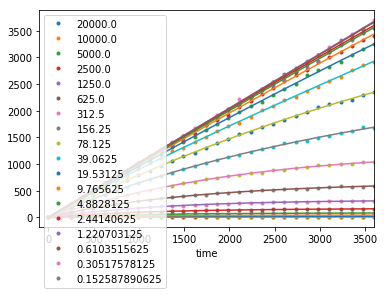

In [7]:
#plot a single fit
k = df_mean.keys()[1]
print(k)
one_fit = act_fit_res[k]
df_mean[k].plot(style = ".", legend = True)
x = np.linspace(df_mean[k].index.min(), df_mean[k].index.max(), 500)
for fit in one_fit:
    plt.plot(x, kobs_activity(fit.params, x))
plt.xlim(-100,3600)
plt.show()

In [8]:
#Fit secondary data 
#Use only a subset of curves
#5 and -7 for simluated data
start = 5
stop = -7
parameter = "kobs"
fit = True

# do the fit
kobs_data, fit_mm = prepare_fit_MM(df_mean, act_fit_res, parameter = parameter, start = start, stop = stop, fit = fit)
for i in kobs_data.keys():
    kobs_data[i]["included"] = "Y"

100%|██████████| 20/20 [00:00<00:00, 269.89it/s]


In [9]:
#use to vizualize results interactively 
def plot_raw(Repeat):
    Repeat = translate[Repeat]
    df_mean[Repeat].plot(yerr = df_error[Repeat], capsize =2)
    plt.show()
    
def plot_fit(Repeat):
    Repeat = translate[Repeat]
    df_mean[Repeat].plot(style = ".", legend = True)
    x = np.linspace(df_mean[Repeat].index.min(), df_mean[Repeat].index.max(), 500)
    for fit in act_fit_res[Repeat]:
        plt.plot(x, kobs_activity(fit.params, x))
    plt.show()
    
def plot_secondary(Repeat):
    Repeat = translate[Repeat]
    #plot secondary linear fit plot
    k_plot = kobs_data[Repeat]
    try:
        ax = k_plot.loc[k_plot.included == "Y"].plot(kind = "scatter", x = "conc", y = "kobs", legend = False)
        k_plot.loc[k_plot.included != "Y"].plot(kind = "scatter", x = "conc", y = "kobs",marker = "s", legend = False, ax = ax, color = "red")
    except:
        pass
    x = np.linspace(0, k_plot["conc"].max(), 500)
    plt.plot(x, michaelis_menten(fit_mm[Repeat].params, x))
    plt.ylim(k_plot["kobs"].min() - k_plot["kobs"].min()*2, k_plot["kobs"].max()*1.5)
    plt.show()

def plot_data_out(Repeat):
    Repeat = translate[Repeat]
    display.display(Repeat)
    display.display(kobs_data[Repeat])
    display.display("MM fit results")
    display.display(Parameters.pretty_print(fit_mm[Repeat].params, columns=['value', "stderr"]))
    #display.display("ODE fit results")
    #display.display(Parameters.pretty_print(ode_fit_res[Repeat].params, columns=['value', "stderr"]))
    d = widgets.SelectMultiple(
    options=kobs_data[Repeat].conc,
    value = list(kobs_data[Repeat].loc[kobs_data[Repeat].included == "Y"].conc.values),
    #rows=10,
    description='Included data for MM fit',
    disabled=False)
    display.display(d)
    d.observe(change_fit_included, names='value')
    
def change_fit_included(change):
    rep = translate[gs[0,0].children[0].value]
    kobs_data[rep].loc[:,"included"] = "N"
    kobs_data[rep].loc[kobs_data[rep].conc.isin(change["new"]),"included"] = "Y"
    try:
        fit_mm[rep] = refit_MM(kobs_data[rep])
        starting_values = {"kinact": fit_mm[rep].params["kinact"].value, "Ki": fit_mm[rep].params["Ki"].value/2}
        #ode_fit_res[rep] = fit_kinact_ode_Ki(df_mean[rep], starting_values = starting_values)
    except:
        pass
    gs[1,1].update()
    gs[1,0].update()

to_include = [x for x in df_mean.keys() if x not in ["Cplus", "Cmin"]]
translate = dict(zip(range(len(to_include)), to_include))
gs = GridspecLayout(2,2)
gs[0,0] = interactive(plot_raw, Repeat=IntSlider(min = 0,max = len(to_include)-1, step  = 1, continuous_update = False))
gs[0,0].layout.height = '350px'
gs[0,1] = interactive(plot_fit, Repeat=IntSlider(min = 0,max = len(to_include)-1, step  = 1, continuous_update = False))
gs[1,0] = interactive(plot_secondary, Repeat=IntSlider(min = 0,max = len(to_include)-1, step  = 1, continuous_update = False))
gs[1,1] = interactive(plot_data_out, Repeat=IntSlider(min = 0,max = len(to_include)-1, step  = 1, continuous_update = False))
widgets.jslink((gs[0,0].children[0], 'value'), (gs[0,1].children[0], 'value'))
widgets.jslink((gs[0,0].children[0], 'value'), (gs[1,0].children[0], 'value'))
widgets.jslink((gs[0,0].children[0], 'value'), (gs[1,1].children[0], 'value'))
gs

GridspecLayout(children=(interactive(children=(IntSlider(value=0, continuous_update=False, description=u'Repea���

To estimate how the error affects obtained values, below Monte Carlo simulations are performed with the same simulated data, but different error amounts. 

In [10]:
fit_data  = {}


for errors in [(0.0, 0.0), (0.01, 0.02), (0.01, 0.04), (0.02, 0.04)]:
    print(errors)
    name = "%i_%i" % (errors[0]*100, errors[1]*100)
    #generate data
    df_mean, df_error = monte_carlo_df(dfs, width_G1 = errors[0], width_G2 = errors[1], repetitions = 50, select = "1")
    #plot the data to get an idea of error
    plt.clf()
    df_mean[0].plot(yerr=df_error[0], capsize=4)
    lg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(name +"_data.png", dpi = 300, bbox_extra_artists=(lg,), bbox_inches='tight')
    ##fitting is done here
    act_fit_res = {}
    for k in tqdm(df_mean.keys()):
        act_fit_res[k] = (fit_kobs_activity(df_mean[k]))
    #do linear fit for mono_exp data
    start = 5
    stop = -7
    parameter = "kobs"
    fit = True

    # do the fit
    # care slope is in nM
    kobs_data, fit_mm = prepare_fit_MM(df_mean, act_fit_res, parameter = parameter, start = start, stop = stop, fit = fit)
    for i in kobs_data.keys():
        kobs_data[i]["included"] = "Y"    
    global_fit_res = {}
    range_min = 5
    range_max = -7
    for k in tqdm(df_mean.keys()):
        #starting_values = {"kinact": fit_mm[i].params["kinact"].value, "Ki": fit_mm[i].params["Ki"].value}
        try:
            global_fit_res[k] = fit_global_activity_kinact(df_mean[k], method = "leastsq")#, starting_values = starting_values))
        except: 
            pass

    for fit_select in ["loc", "glob"]:
        for param in ["Ki", "kinact"]:
            if fit_select == "loc":
                fit_data[name + "_loc_" + param] = []
                for f in fit_mm:
                    fit_data[name + "_loc_" + param].append(fit_mm[f].params[param].value)
            elif fit_select == "glob":
                fit_data[name + "_glob_" + param] = []
                for f in global_fit_res:
                    fit_data[name + "_glob_" + param].append(global_fit_res[f].params[param].value)

fit_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in fit_data.iteritems() ]))

  6%|▌         | 3/50 [00:00<00:01, 28.94it/s]

(0.0, 0.0)


  6%|▌         | 3/50 [00:00<00:01, 27.77it/s]

(0.01, 0.02)


  6%|▌         | 3/50 [00:00<00:01, 23.85it/s]

(0.01, 0.04)


  6%|▌         | 3/50 [00:00<00:02, 23.01it/s]

(0.02, 0.04)


100%|██████████| 50/50 [01:43<00:00,  2.08s/it]


Then we plot kinact and Ki and generate a table with mean / sd and CV values

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

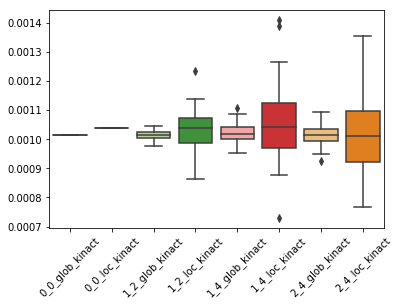

In [11]:
#Plot kinact
plt.clf()
chart = sns.boxplot( data = fit_df.loc[:,fit_df.columns.str.contains("kinact")].dropna(axis = 1, how = "all"), palette = "Paired")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
#plt.ylim(0.,0.0015)
plt.savefig("kinact.png", dpi = 300, bbox_inches = "tight")

plt.show()

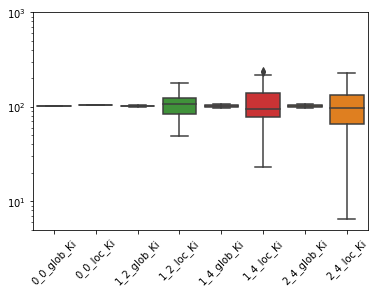

In [12]:
#plot Ki
chart = sns.boxplot( data = fit_df.loc[:,fit_df.columns.str.contains("Ki")].dropna(axis = 1, how = "all"), palette = "Paired")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.savefig("Ki.png", dpi = 300, bbox_inches = "tight")
plt.ylim(5,1000)
plt.yscale("log")
plt.show()

In [13]:
#Generate a dataframe with the mean / sd results for different errors 
results = pd.DataFrame([fit_df.mean(),fit_df.std()]).T
results.columns = ["mean", "stdev"]
results["cv"] = results["stdev"] / results["mean"]
results.to_excel("comparison.xlsx")